###  Practicum #1 - Maggie Sleziak
####  Regis University

<B> 
<BR>Daily Summary from the Station at the Denver International Airport. 
<BR>Data-range: January 1, 2010 to August 26, 2018. 
<BR>Main features are average of temperature, humidity and dew. 
<BR>Using 3 days (3 lag) data to predict current day temp based on the past 3 days 
<BR>of weather information. 
<BR>Dataset from: 
<BR>National Centers for Environmental Information,  NCEI. Climate Data Online. 
<BR>Retrieved from https://www.ncdc.noaa.gov/cdo-web/

<BR>Exploration non deep learning ML algorithms for a 
<BR> multivariate time series problem. 
<B>

<br>
<br>

In [1]:

# Load libraries
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.stats.stattools import jarque_bera
from statsmodels import regression, stats
import statsmodels.api as sms
import statsmodels.stats.diagnostic as smd

%matplotlib inline


In [2]:

# - Load dataset prepared by R - This is the 3 day lag dataset. 
# In this case the yTavg is our Target/Predictand/Dependent variable or Y
dailyLag1 = pd.read_csv("./data/dailyLag3.csv")
print
print('Info:')
dailyLag1.info()
print
print('head:')
dailyLag1.head(5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 10 columns):
hum3     3157 non-null int64
hum2     3157 non-null int64
hum1     3157 non-null int64
dewp3    3157 non-null int64
dewp2    3157 non-null int64
dewp1    3157 non-null int64
tavg3    3157 non-null float64
tavg2    3157 non-null float64
tavg1    3157 non-null float64
yTavg    3157 non-null float64
dtypes: float64(4), int64(6)
memory usage: 246.7 KB
head:


,hum3,hum2,hum1,dewp3,dewp2,dewp1,tavg3,tavg2,tavg1,yTavg
0,59,74,80,13,21,23,26.0,28.0,26.0,23.5
1,74,80,68,21,23,15,28.0,26.0,23.5,33.0
2,80,68,52,23,15,21,26.0,23.5,33.0,18.0
3,68,52,77,15,21,10,23.5,33.0,18.0,-1.5
4,52,77,67,21,10,-9,33.0,18.0,-1.5,11.0


In [3]:
# Turn all values into a float
values = dailyLag1.values
values = values.astype('float32')

tempValues = pd.DataFrame(values) 
tempValues.columns = ['hum3', 'hum2', 'hum1', 'dewp3', 'dewp2', 'dewp1', 'tavg3', 'tavg2', 'tavg1', 'yTavg']
print('After changing to float: ')
print(tempValues.head(10))
print()
print()
# Check again for nan - should be negative due to previous work in R
print('Checking for missing values: ')
print(np.isnan(tempValues).any())
print(np.isinf(tempValues).any())
print()
print()
print('Data Types: ')
print(tempValues.dtypes)

After changing to float: 
   hum3  hum2  hum1  dewp3  dewp2  dewp1  tavg3  tavg2  tavg1  yTavg
0  59.0  74.0  80.0   13.0   21.0   23.0   26.0   28.0   26.0   23.5
1  74.0  80.0  68.0   21.0   23.0   15.0   28.0   26.0   23.5   33.0
2  80.0  68.0  52.0   23.0   15.0   21.0   26.0   23.5   33.0   18.0
3  68.0  52.0  77.0   15.0   21.0   10.0   23.5   33.0   18.0   -1.5
4  52.0  77.0  67.0   21.0   10.0   -9.0   33.0   18.0   -1.5   11.0
5  77.0  67.0  52.0   10.0   -9.0   -2.0   18.0   -1.5   11.0   25.0
6  67.0  52.0  49.0   -9.0   -2.0    9.0   -1.5   11.0   25.0   32.0
7  52.0  49.0  55.0   -2.0    9.0   16.0   11.0   25.0   32.0   34.0
8  49.0  55.0  57.0    9.0   16.0   18.0   25.0   32.0   34.0   38.0
9  55.0  57.0  46.0   16.0   18.0   16.0   32.0   34.0   38.0   43.0


Checking for missing values: 
hum3     False
hum2     False
hum1     False
dewp3    False
dewp2    False
dewp1    False
tavg3    False
tavg2    False
tavg1    False
yTavg    False
dtype: bool
hum3     False
hum2  

In [4]:
# Split into train and test sets with X (features/predictors) and Y (output/target)
# There are 8 years total, fit only model for the first 6 years, then evaluate on the other 2.x
# In Time Series we need to keep the order of the data as this represents the time. 
train_days = 365 * 5
train = values[:train_days, :]
print('Train first 5 :')
print(train[:5,])
print

Train first 5 :
[[59.  74.  80.  13.  21.  23.  26.  28.  26.  23.5]
 [74.  80.  68.  21.  23.  15.  28.  26.  23.5 33. ]
 [80.  68.  52.  23.  15.  21.  26.  23.5 33.  18. ]
 [68.  52.  77.  15.  21.  10.  23.5 33.  18.  -1.5]
 [52.  77.  67.  21.  10.  -9.  33.  18.  -1.5 11. ]]


<function print>

In [5]:
# User remeinder for testing 
test = values[train_days:, :]
print('Test first 5 :')
print(test[:5,])
print

Test first 5 :
[[63.  69.  75.   2.   7.  14.   8.5 15.5 23.  15. ]
 [69.  75.  79.   7.  14.  10.  15.5 23.  15.  13. ]
 [75.  79.  74.  14.  10.   2.  23.  15.  13.  25.5]
 [79.  74.  59.  10.   2.  20.  15.  13.  25.5 34.5]
 [74.  59.  75.   2.  20.  30.  13.  25.5 34.5 26.5]]


<function print>

In [6]:
# Split train into X and y = where y is the Target/Predictand. 
# All but last column in to X, last column into Y
train_X, train_y = train[:, :-1], train[:, -1]
print('Train only features first 5 :')
print(train_X[:5,])
print()
print('Train only Y first 5 :')
print(train_y[:5,])
print()

print('Head from original:')
dailyLag1.head(5)

Train only features first 5 :
[[59.  74.  80.  13.  21.  23.  26.  28.  26. ]
 [74.  80.  68.  21.  23.  15.  28.  26.  23.5]
 [80.  68.  52.  23.  15.  21.  26.  23.5 33. ]
 [68.  52.  77.  15.  21.  10.  23.5 33.  18. ]
 [52.  77.  67.  21.  10.  -9.  33.  18.  -1.5]]

Train only Y first 5 :
[23.5 33.  18.  -1.5 11. ]

Head from original:


,hum3,hum2,hum1,dewp3,dewp2,dewp1,tavg3,tavg2,tavg1,yTavg
0,59,74,80,13,21,23,26.0,28.0,26.0,23.5
1,74,80,68,21,23,15,28.0,26.0,23.5,33.0
2,80,68,52,23,15,21,26.0,23.5,33.0,18.0
3,68,52,77,15,21,10,23.5,33.0,18.0,-1.5
4,52,77,67,21,10,-9,33.0,18.0,-1.5,11.0


In [7]:
# Do the same for the test (Validation) set: 
test_X, test_y = test[:, :-1], test[:, -1]
print('Test only features first 5 :')
print(test_X[:10,])
print()
print('Test only Y first 5 :')
print(test_y[:10,])
print()

Test only features first 5 :
[[63.  69.  75.   2.   7.  14.   8.5 15.5 23. ]
 [69.  75.  79.   7.  14.  10.  15.5 23.  15. ]
 [75.  79.  74.  14.  10.   2.  23.  15.  13. ]
 [79.  74.  59.  10.   2.  20.  15.  13.  25.5]
 [74.  59.  75.   2.  20.  30.  13.  25.5 34.5]
 [59.  75.  86.  20.  30.  16.  25.5 34.5 26.5]
 [75.  86.  61.  30.  16.  24.  34.5 26.5 34. ]
 [86.  61.  89.  16.  24.  19.  26.5 34.  22. ]
 [61.  89.  65.  24.  19.  26.  34.  22.  39. ]
 [89.  65.  77.  19.  26.  27.  22.  39.  33.5]]

Test only Y first 5 :
[15.  13.  25.5 34.5 26.5 34.  22.  39.  33.5 25. ]



In [8]:
print('Check the shape to ensure proper splits  :')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print()

Check the shape to ensure proper splits  :
(1825, 9) (1825,) (1332, 9) (1332,)



In [9]:
# Test options and evaluation metric
folds = 10
instances = len(train_X) 
seed = 10
# Using mean squared error for tuning and cross validation. 
scoring = 'neg_mean_squared_error'
# From: http://scikit-learn.org/stable/modules/model_evaluation.html
# Returns a negated value of the loss either in float or ndarray of floats (the best value is 0.0), 
# Since all scorer objects follow the convention that higher return values are better than lower return values. 
# then metrics which measure the distance between the model and the data, 
# like metrics.mean_squared_error, are available as neg_mean_squared_error 
# which return the negated value of the metric.

In [10]:
# Fitting and then testing models
# In time series we do not use cross validation

scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
rescaledX = scaler.transform(train_X)
rescaledValidationX = scaler.transform(test_X)

modelsToFit = []
modelsToFit.append(('AdaBoost Regressor (Scaled)', 'AdaBoost', AdaBoostRegressor(random_state=seed, n_estimators=400)))
modelsToFit.append(('Gradient Boosting Regressor (Scaled)', 'GradientBoost', GradientBoostingRegressor(random_state=seed, n_estimators=400)))
modelsToFit.append(('Linear Regression (Scaled)', 'LR', LinearRegression())) 
modelsToFit.append(('K Neighbors Regressor (Scaled)', 'KNN',  KNeighborsRegressor(n_neighbors=23)))
modelsToFit.append(('S-Lasso (Scaled)', 'LASSO',  Lasso()))
modelsToFit.append(('Decision Tree Regressor (Scaled)', 'CART',  DecisionTreeRegressor()))
modelsToFit.append(('Support Vector Regressor (Scaled)', 'SVR',  SVR()))
modelsToFit.append(('Extra Trees Regressor (Scaled)', 'ExtraTree',  ExtraTreesRegressor()))
modelsToFit.append(('Random Forest Regressor (Scaled)', 'RadomForest',  RandomForestRegressor()))
modelsToFit.append(('Elasic Net (Scaled)','ElasticNet',  ElasticNet()))



Fit and Predict different models for Time Series: 

AdaBoost Regressor (Scaled) model fit on rescaled train X, and train Y.
Predict on rescaled test Y


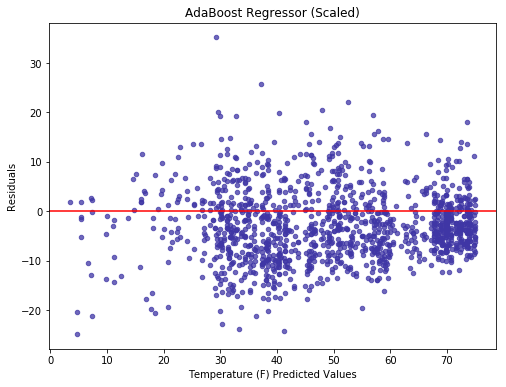

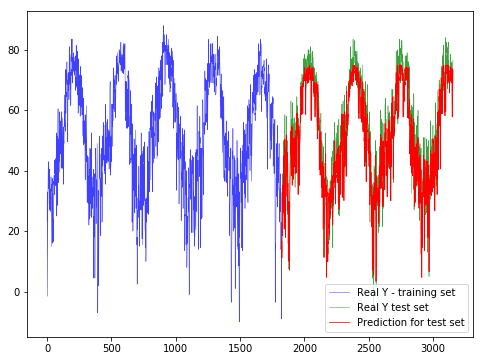

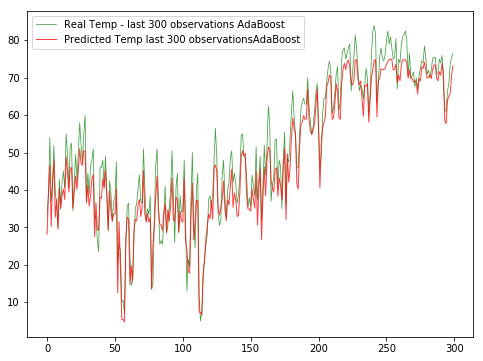

Test for normal distribution of the residuals
Pvalue: 3.7003276467623057e-26
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [2.79182886e-03 2.66588749e-07 1.25897331e-11]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 7.09298277045198e-14
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 58.782447

Model:  AdaBoost Regressor (Scaled)
MSE : 58.782
Variance score: 0.81
RMSE : 7.667

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


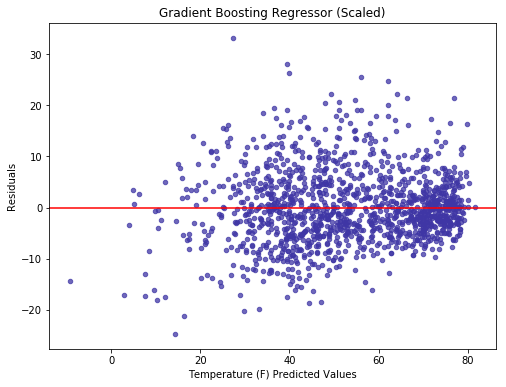

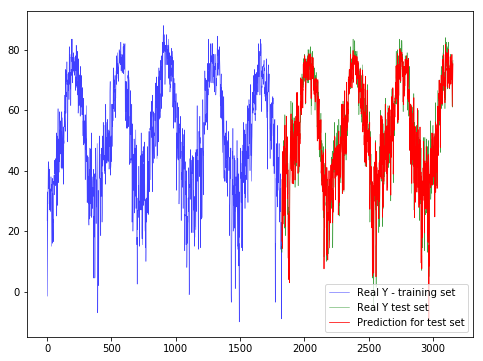

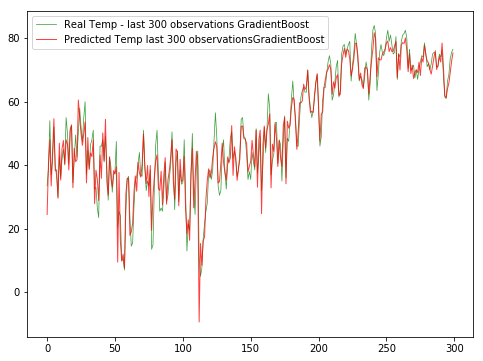

Test for normal distribution of the residuals
Pvalue: 3.879691054008599e-24
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [0.00705294 0.00881342 0.00321842]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 4.2032759237513735e-19
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 51.401042

Model:  Gradient Boosting Regressor (Scaled)
MSE : 51.401
Variance score: 0.84
RMSE : 7.169
R

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


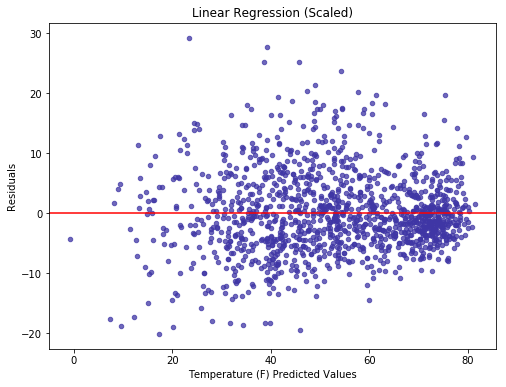

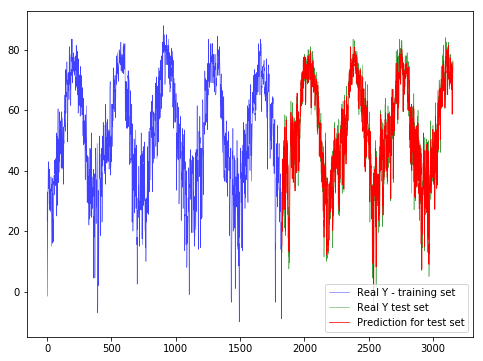

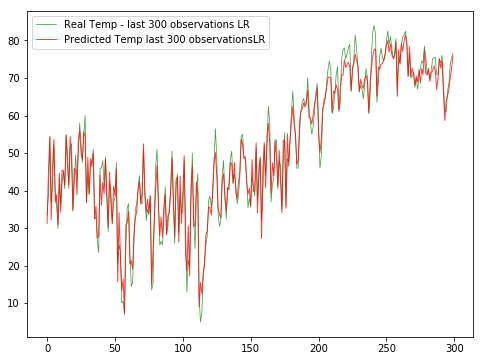

Test for normal distribution of the residuals
Pvalue: 3.995253455132189e-27
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [0.00626155 0.0100079  0.00015947]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 7.030870796473606e-19
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 45.199245

Model:  Linear Regression (Scaled)
MSE : 45.199
Variance score: 0.86
RMSE : 6.723
R2Score: 0.8

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


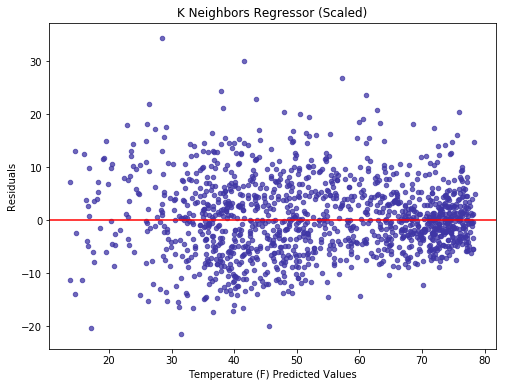

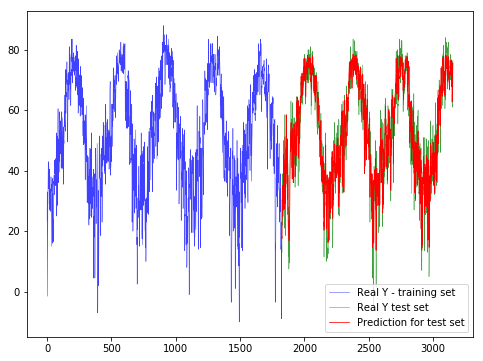

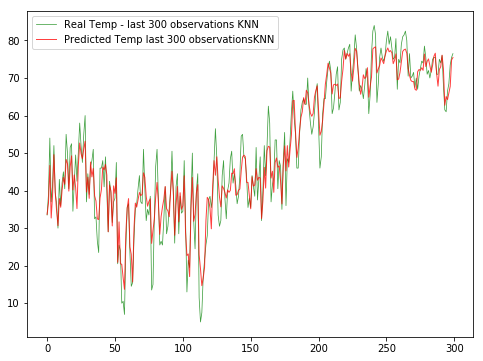

Test for normal distribution of the residuals
Pvalue: 8.508724897735345e-15
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [3.72699043e-18 6.71332884e-20 2.03963787e-25]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 1.272019069692991e-17
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 50.976269

Model:  K Neighbors Regressor (Scaled)
MSE : 50.976
Variance score: 0.84
RMSE : 7.

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


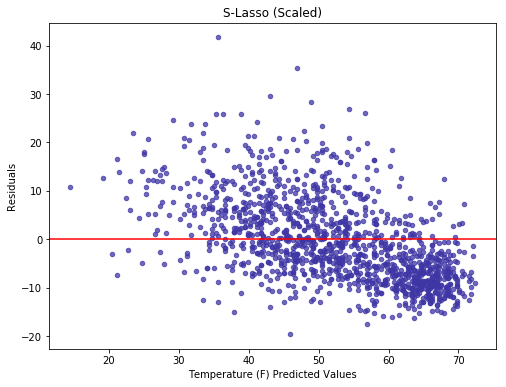

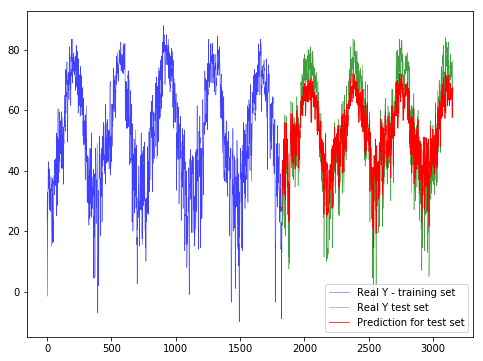

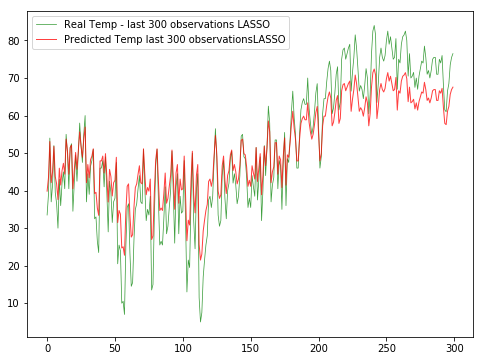

Test for normal distribution of the residuals
Pvalue: 3.162180875975252e-33
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [6.07622290e-066 6.76460496e-092 2.04905967e-131]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 4.264498874007835e-07
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 75.259468

Model:  S-Lasso (Scaled)
MSE : 75.259
Variance score: 0.76
RMSE : 8.675
R2Score

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


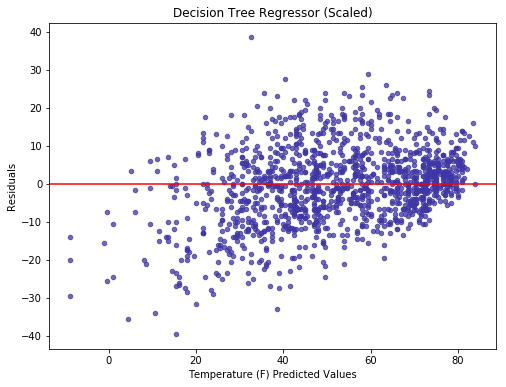

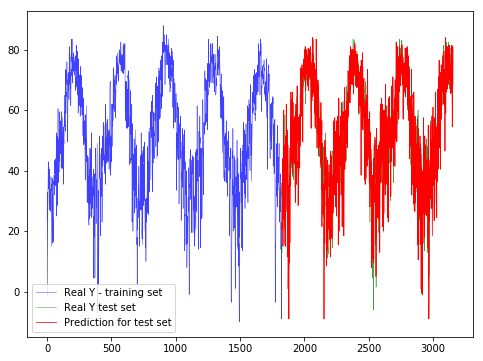

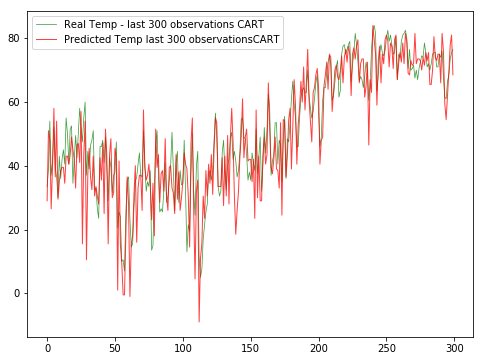

Test for normal distribution of the residuals
Pvalue: 3.8953199257088956e-07
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [0.75698888 0.11428386 0.20712401]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are not autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 2.768302396814864e-19
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 99.294294

Model:  Decision Tree Regressor (Scaled)
MSE : 99.294
Variance score: 0.69
RMSE : 9.965
R

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


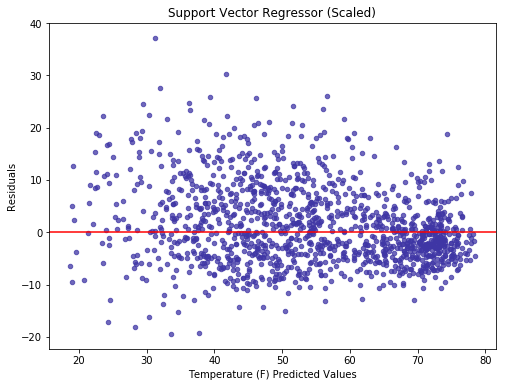

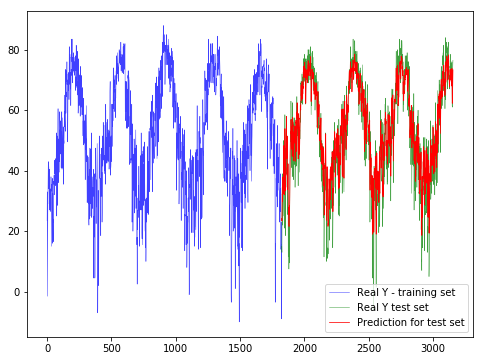

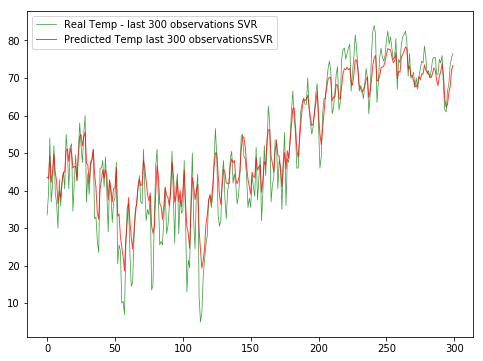

Test for normal distribution of the residuals
Pvalue: 6.5562188286594e-33
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [3.22524092e-41 1.15922707e-40 4.82199822e-45]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 3.304106621223447e-31
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 58.231665

Model:  Support Vector Regressor (Scaled)
MSE : 58.232
Variance score: 0.82
RMSE : 7

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


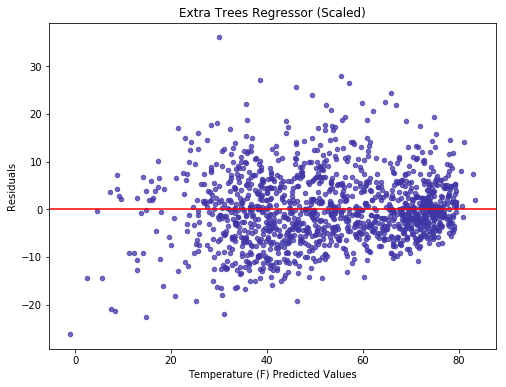

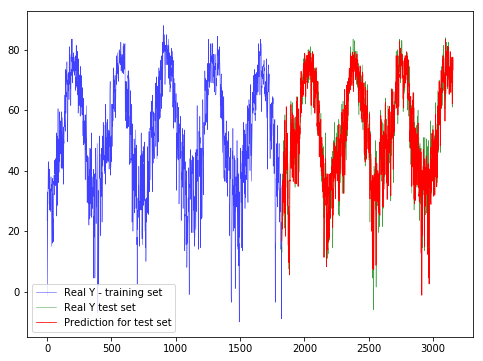

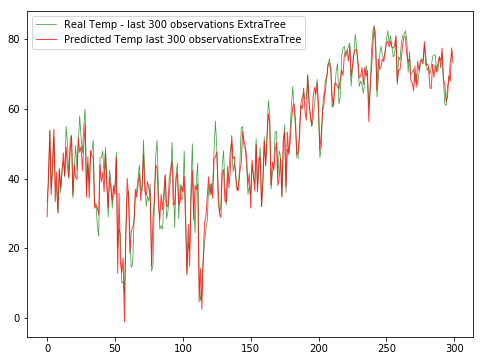

Test for normal distribution of the residuals
Pvalue: 2.0914746853671235e-25
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [7.50896742e-01 1.30331837e-03 7.60748623e-05]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 1.9458547888598362e-15
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 53.386380

Model:  Extra Trees Regressor (Scaled)
MSE : 53.386
Variance score: 0.83
RMSE : 

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


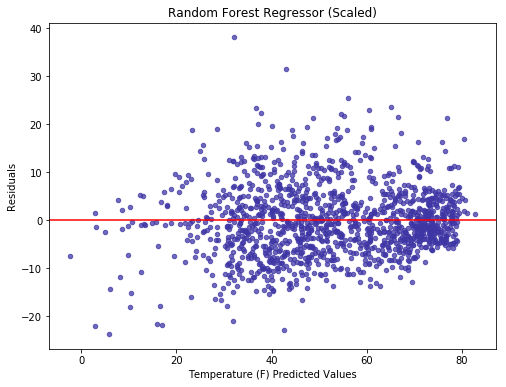

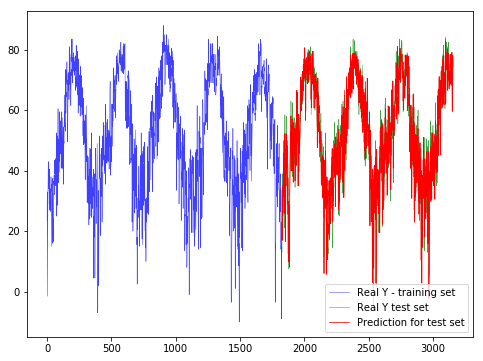

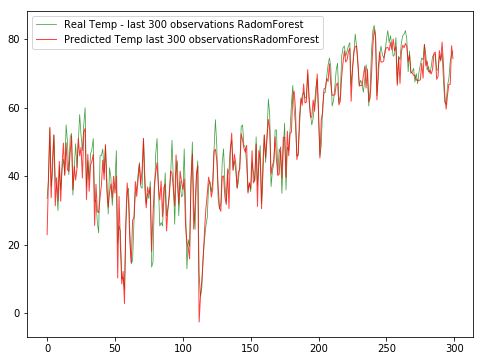

Test for normal distribution of the residuals
Pvalue: 2.77768525486522e-27
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [9.10155203e-01 4.94395313e-03 3.96339156e-05]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 2.6976169110107734e-15
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 54.172554

Model:  Random Forest Regressor (Scaled)
MSE : 54.173
Variance score: 0.83
RMSE : 

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


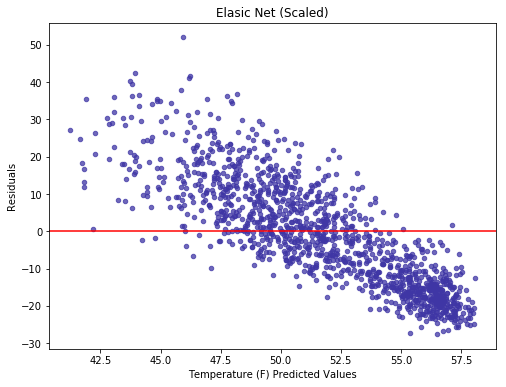

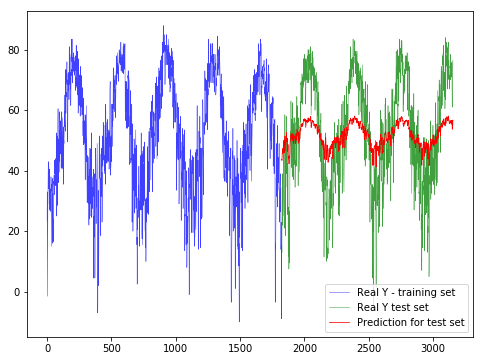

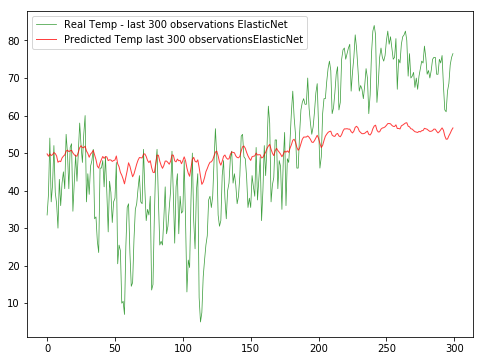

Test for normal distribution of the residuals
Pvalue: 1.2212335830282999e-12
If the above pvalue fall below the significance level/alpha (e.g. p<0.05)
then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed
Not normal distribution

Test for Autocorrelation
P-values: [7.54484514e-217 0.00000000e+000 0.00000000e+000]
If any of the p-value fall below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.

The residuals are autocorrelated.

Test for consistent standard errors,
Breusch-Pagan test for Heteroskedasticity: 1.2771679112020201e-17
If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
No constant variance

Residual sum of squares (Same as MSE): 209.795074

Model:  Elasic Net (Scaled)
MSE : 209.795
Variance score: 0.33
RMSE : 14.484

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')


In [11]:
# Get all info for each model to add to a file

names = []
nicknames = []
model_rmse = []
model_r2 = []
model_mse = []
model_autocorr = []
model_normal = []
model_variance = []
model_mape = []

plt.rcParams['figure.figsize'] = [8, 6]

print("Fit and Predict different models for Time Series: ")
for name, nickname, model in modelsToFit:
  nicknames.append(nickname)
  names.append(name)
  print()
  print(name, "model fit on rescaled train X, and train Y.")
  print("Predict on rescaled test Y")
  model.fit(rescaledX, train_y)
  predictions = model.predict(rescaledValidationX)
  residuals = predictions - test_y
  # Plot predictions and residuals             
  plt.scatter(model.predict(rescaledValidationX), residuals, s = 20, color = '#3f36a5', alpha = 0.75);
  plt.axhline(0, color='red')
  plt.xlabel('Temperature (F) Predicted Values')
  plt.ylabel('Residuals')
  plt.title(name)
  plt.show()
  
  
  # Because X (and thus predictions) is one day behind Y. The time series plot look a bit off. 
  # Let's place back the data so we can see the plots better
  # The prediction “prediction” is one index ahead of real output “test_y”.
  plot_train_y = train_y[:-1]
  plot_y = test_y[:-1]
  plot_predictions = predictions[1:]
  plt.plot(plot_train_y,color='blue', label = 'Real Y - training set', lw = 0.5, alpha = 0.75)
  plt.plot([None for i in plot_train_y] + [x for x in plot_y], color='green', label = 'Real Y test set', lw = 0.5, alpha = 0.75)
  plt.plot([None for i in plot_train_y] + [x for x in plot_predictions], color='red', label = 'Prediction for test set',lw = 0.75, alpha = 1)
  plt.legend()
  plt.show()
    
  plt.plot(plot_y[-300:], color='green', lw = 0.75,  alpha = 0.75, label = 'Real Temp - last 300 observations ' + nickname)
  plt.plot(plot_predictions[-300:], color='red', lw = 1, alpha = 0.75, label = 'Predicted Temp last 300 observations' + nickname)
  plt.legend()
  plt.show()

  # Take a look more at the residuals: 
  
  # Normal Distribution 
  _, pvalue, _, _ = jarque_bera(residuals)
  print ("Test for normal distribution of the residuals") 
  print ("Pvalue:", pvalue)
  print ("If the above pvalue fall below the significance level/alpha (e.g. p<0.05)") 
  print ("then the null hypotheses that data is normally distributed is rejected, an not normal distribution is assumed")
  if (pvalue < 0.05):
    print ("Not normal distribution")
    model_normal.append('Not normal distribution')
  else:
    print ("Normal Distribution")
    model_normal.append('normal distribution')
    
 
  p_autocorrelation = smd.acorr_ljungbox(residuals, lags=3)  
  print()
  print ("Test for Autocorrelation")
  print ("P-values:", p_autocorrelation[1])
  
  print ("If any of the p-value fall below the significance level/alpha (e.g. p<0.05)") 
  print ("then the null hypothesis of no autocorrelation is rejected and autocorrelation is assumed.")
  print()
  if any(p_autocorrelation[1] < 0.05):
    print ("The residuals are autocorrelated.")
    model_autocorr.append('Residuals autocorrelated')
  else:
    print ("The residuals are not autocorrelated.")
    model_autocorr.append('Residuals No-autocorrelated')
    
  # homoskedasticity refers to a condition in which the variance of the residual, 
  # or error term, in a regression model is constant. 
  # That is, the error term does not vary much as the value of the predictor variable changes.
  print()
  print("Test for consistent standard errors,")
  x_constant = sms.add_constant(rescaledValidationX)
  _, pvalue1, _, _ = stats.diagnostic.het_breushpagan(residuals, x_constant)
  print ("Breusch-Pagan test for Heteroskedasticity:", pvalue1)
  print ("If the test statistic has a p-value below the significance level/alpha (e.g. p<0.05)") 
  print ("then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.")
  if (pvalue < 0.05):
    print ("No constant variance")
    model_variance.append('No constant variance')
  else:
    print ("Constant variance")
    model_variance.append('Constant variance')

  
  mse = mean_squared_error(test_y, predictions)
  model_mse.append(mse)
  rmse = sqrt(mean_squared_error(test_y, predictions))
  model_rmse.append(rmse)
  r2score = r2_score(test_y, predictions)
  model_r2.append(r2score)
  print()
  print("Residual sum of squares (Same as MSE): %f"% np.mean(residuals ** 2))
  print()
  print ("Model: ", name)
  print('MSE : %.3f' % mse)
  print('Variance score: %.2f' % model.score(rescaledValidationX, test_y))
  print('RMSE : %.3f' % rmse)
  # R^2 (coefficient of determination - Goodness of fit) regression score function.
  r2score = r2_score(test_y, predictions)
  print('R2Score: %.3f' % r2score)

  # Mean Absolute Percentage Error
  # http://mariofilho.com/create-simple-machine-learning-model-predict-time-series/
  # MAPE, as it is scale-independent 
  # and represents the ratio of error to actual values as a percent
  def mape(y_pred,y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  mapescore = mape(predictions,test_y)
  model_mape.append(mapescore)
  print('Mean Absolute Percentage Error: %.3f' % mapescore)
  print()
  print('________________________________________________________________________________')
  

In [12]:

predictionSummary = pd.DataFrame({'Model':np.array(nicknames),
                                  'R2':np.array(model_r2),
                                  'RMSE':np.array(model_rmse),
                                  'MSE':np.array(model_mse),
                                  'MAPE': np.array(model_mape),
                                  'Normaldistribution':model_normal,
                                  'Variance':model_variance,
                                  'Autocorrelation':model_autocorr })


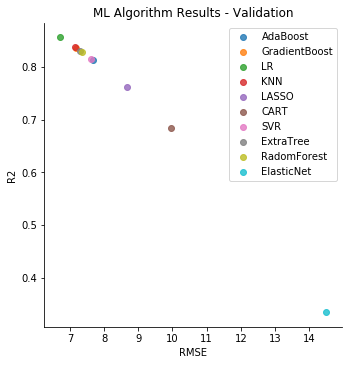

In [13]:

# Factor variable with hue: 
sns.lmplot( x="RMSE", y="R2", data=predictionSummary, fit_reg=False, hue='Model', legend=False)
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_title("ML Algorithm Results - Validation")
plt.savefig('./data/model_validation.png')

In [14]:

print('Results - Sorted by R2 (Coefficient Of Determination - Goodness of fit) :')
print()
print('Observations: %d' % (len(train) + len(test)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
predictionSummaryFile = predictionSummary.set_index(['Model'])
predictionSummaryFile = predictionSummaryFile.sort_values(by=['R2'], ascending=False)
print(predictionSummaryFile) 

Results - Sorted by R2 (Coefficient Of Determination - Goodness of fit) :

Observations: 3157
Training Observations: 1825
Testing Observations: 1332
                     R2       RMSE         MSE       MAPE  \
Model                                                       
LR             0.856686   6.723038   45.199245  14.289601   
KNN            0.838369   7.139767   50.976269  16.257240   
GradientBoost  0.837022   7.169452   51.401042  14.860298   
ExtraTree      0.830727   7.306598   53.386380  15.160497   
RadomForest    0.828235   7.360201   54.172554  14.845596   
SVR            0.815364   7.630968   58.231665  19.142214   
AdaBoost       0.813618   7.666971   58.782447  14.932669   
LASSO          0.761374   8.675222   75.259468  20.955628   
CART           0.685167   9.964652   99.294294  19.851463   
ElasticNet     0.334801  14.484304  209.795074  36.782625   

                    Normaldistribution              Variance  \
Model                                                 

In [15]:
# We can see how Linear Regression with Scaled data is the one that is performing 
# the best from all Regressor ML algs tested. 
# save this format to a file

predictionSummaryFile.to_csv('./data/RegressorsSummary.csv')